## 패키지 로드

In [207]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

import os
import random
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict, Counter

from scipy import interpolate

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

import wandb

import plotnine
from plotnine import *

In [211]:
# 하이퍼파라미터
class cfg:
    seed=1234
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    
    # 경로설정
    base_path = "/home/seon/workspace/competition/aifactory/anomaly_detection_comp"
    
    # 모델이름
    model_name = 'DeepSVDD'

In [3]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
seed_everything(cfg.seed)

In [4]:
train_data = pd.read_csv(os.path.join(cfg.base_path,"dataset", "train_data.csv"))
train_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [5]:
test_data=pd.read_csv(os.path.join(cfg.base_path,"dataset", "test_data.csv"))
test_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,0
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,0
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,0
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,0
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,0
...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7


2. 또한 설비별로 다음의 특성을 갖습니다.   
- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)   
- 설비 번호 1: 20HP   
- 설비 번호 2: 10HP   
- 설비 번호 3: 50HP   


In [6]:
# 마력 컬럼 추가
train_data.loc[train_data[train_data.type == 1].index, "hp"] = 20
train_data.loc[train_data[train_data.type == 2].index, "hp"] = 10
train_data.loc[train_data[train_data.type == 3].index, "hp"] = 50
train_data.hp.fillna(30, inplace=True)

test_data.loc[test_data[test_data.type == 1].index, "hp"] = 20
test_data.loc[test_data[test_data.type == 2].index, "hp"] = 10
test_data.loc[test_data[test_data.type == 3].index, "hp"] = 50
test_data.hp.fillna(30, inplace=True)

In [7]:
new_column = ['out_pressure', 'air_inflow', 'air_end_temp', 'motor_current',
       'motor_rpm', 'motor_temp', 'motor_vibe', 'type', 'hp']

train_data = train_data[new_column]
test_data = test_data[new_column]

In [8]:
outlier_pressure = test_data[test_data.out_pressure != 0.7].index
outlier_pressure

Int64Index([4917, 4918, 4919, 4920, 4921, 4922, 4923], dtype='int64')

## 추가 전처리

In [9]:
# motor_vibe 이상치 제거
outlier_idx = train_data[train_data.motor_vibe > 6].index

train_data = train_data.drop(index=outlier_idx)
train_data.reset_index(drop=True, inplace=True)

In [10]:
train_set = dict()
test_set = dict()
for hptype in [10, 20, 30, 50]:
    train_set[f'{hptype}HP'] = train_data[train_data.hp == hptype]
    test_set[f'{hptype}HP'] = test_data[test_data.hp == hptype]

In [11]:
# 그래프 시각화
def plot_graph(df, title):
    x = np.arange(len(df.columns))
    plt.figure(figsize=(6,3))
    for i in range(len(df)):
        plt.plot(x, df.iloc[i,:])
    plt.title(f"{title}")
    plt.show()

### 스케일링


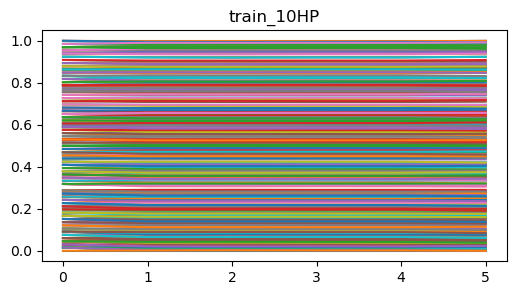

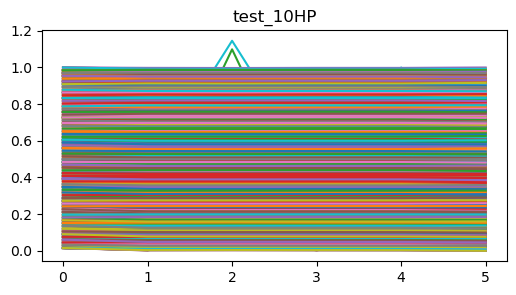

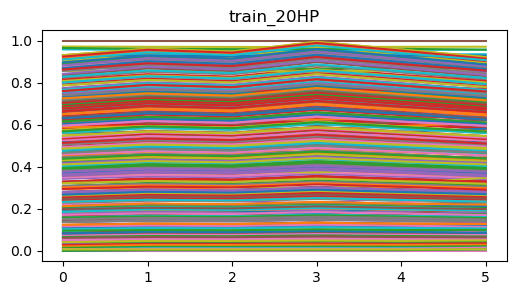

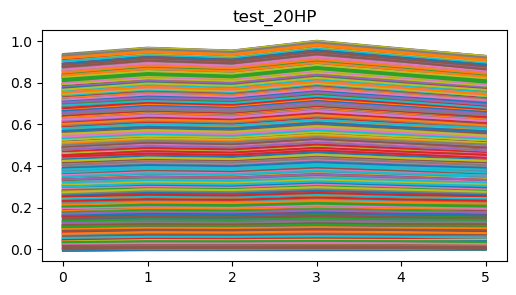

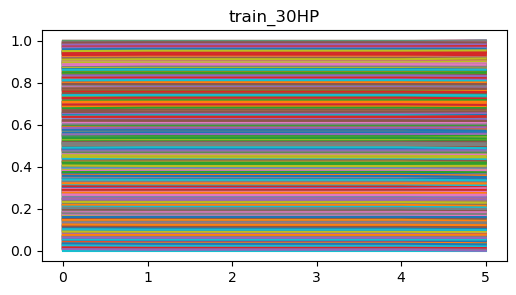

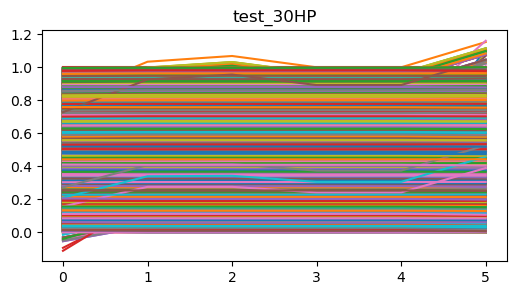

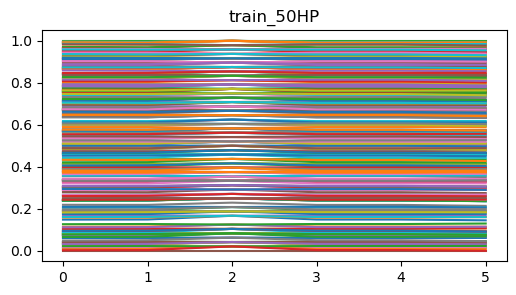

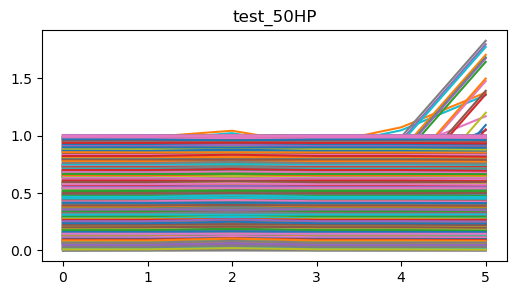

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def scaling(train, test, scaler):
    scaled_train = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
    scaled_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
    return scaled_train, scaled_test

scaled_train = dict()
scaled_test = dict()
for hp in ["10HP", "20HP", "30HP", "50HP"]:
    scaled_train[hp], scaled_test[hp] = scaling(train_set[hp].iloc[:,1:-2], test_set[hp].iloc[:,1:-2],
                                                MinMaxScaler())
    plot_graph(scaled_train[hp], f'train_{hp}')
    plot_graph(scaled_test[hp], f'test_{hp}')


In [13]:
scaled_train["10HP"]

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe
785,0.439394,0.443240,0.443810,0.443456,0.443385,0.442748
786,0.363636,0.364622,0.364762,0.364676,0.364468,0.366412
787,0.181818,0.182311,0.182857,0.182550,0.182234,0.183206
788,0.060606,0.049136,0.049524,0.049132,0.048799,0.045802
789,0.272727,0.268384,0.268571,0.268530,0.268395,0.267176
...,...,...,...,...,...,...
1146,0.530303,0.525923,0.525714,0.526048,0.526115,0.526718
1147,0.363636,0.356828,0.357143,0.357052,0.356843,0.358779
1148,0.712121,0.714334,0.714286,0.714528,0.714449,0.717557
1149,0.848485,0.849881,0.849524,0.850064,0.850172,0.847328


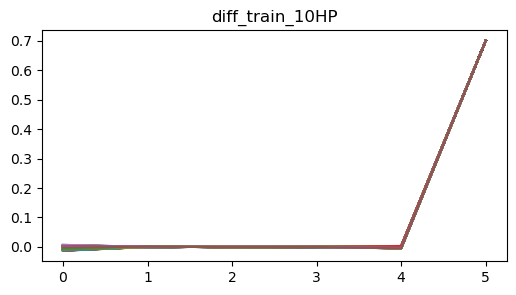

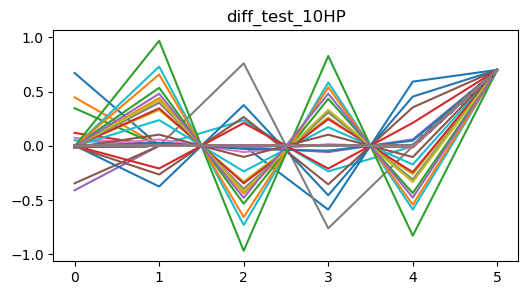

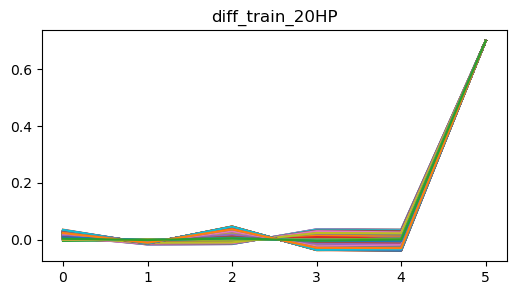

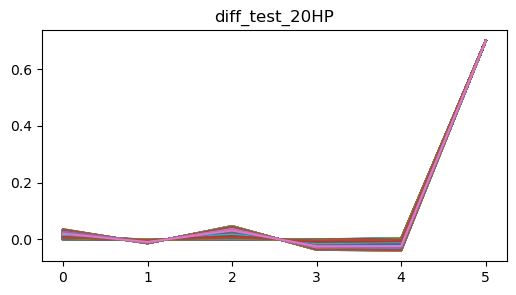

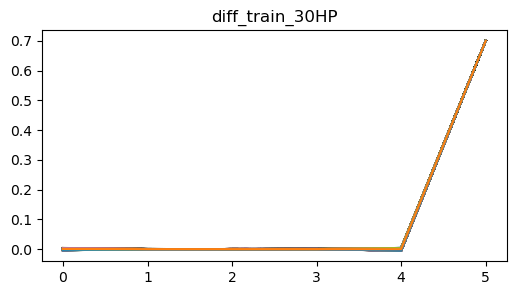

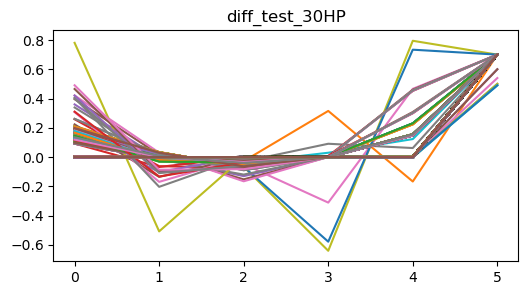

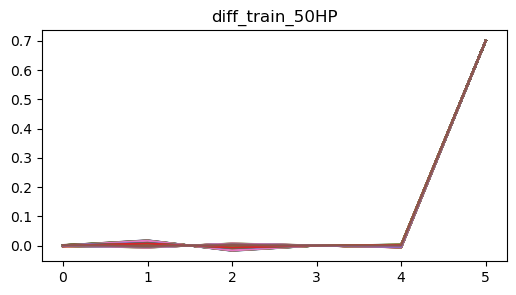

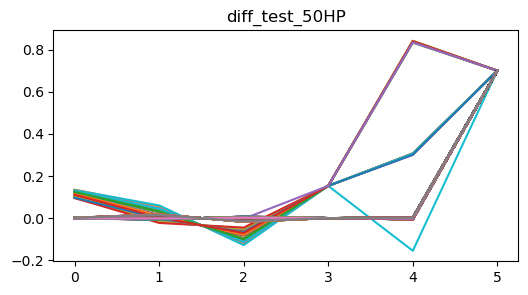

In [14]:
# 각 행에 대한 기울기 계산
def derivative(df):
    deriv_df = pd.DataFrame()
    for i in range(len(df.columns)-1):
        diff = df.apply(lambda x: x[i+1] - x[i], axis=1)
        deriv_df[f"diff{i+1}"] = diff
    return deriv_df

deriv_train = dict()
deriv_test = dict()
for hp in scaled_train.keys():
    deriv_train[hp] = derivative(scaled_train[hp])
    deriv_test[hp] = derivative(scaled_test[hp])

for hp in deriv_train.keys():
    deriv_train[hp]["out_pressure"] = train_data.out_pressure
    deriv_test[hp]["out_pressure"] = test_data.out_pressure
    plot_graph(deriv_train[hp], f"diff_train_{hp}")
    plot_graph(deriv_test[hp], f"diff_test_{hp}")

In [15]:
all_type_deriv_train = pd.concat([deriv_train["10HP"],
                                  deriv_train["20HP"],
                                  deriv_train["30HP"],
                                  deriv_train["50HP"]])

all_type_deriv_test = pd.concat([deriv_test["10HP"],
                                  deriv_test["20HP"],
                                  deriv_test["30HP"],
                                  deriv_test["50HP"]])

all_type_deriv_train.sort_index(inplace=True)
all_type_deriv_test.sort_index(inplace=True)

In [16]:
# 기울기 데이터프레임에 대해 pca로 시각화

def pca(train, test, n = 2):
    pca = PCA(n_components=n, random_state=cfg.seed)
    pca_train = pca.fit_transform(train)
    pca_test = pca.transform(test)
    if n == 2:
        pca_train = pd.DataFrame(pca_train, index=train.index, columns=['x','y'])
        pca_test = pd.DataFrame(pca_test, index=test.index, columns=['x','y'])
    elif n == 3:
        pca_train = pd.DataFrame(pca_train, index=train.index, columns=['x','y','z'])
        pca_test = pd.DataFrame(pca_test, index=test.index, columns=['x','y','z'])
    else:
        pass
    return pca_train, pca_test

def plot_pca(train, test, n = 2):
    fig = plt.figure(figsize=(15,10))
    if n == 2:
        ax = fig.add_subplot(111)
        ax.scatter(train['x'], train['y'], s=10, color='b', label='train')
        ax.scatter(test['x'], test['y'], s=1, color='r', label='test')
    elif n == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(train['x'], train['y'], train['z'], s=10, color='b', alpha=0.5, label='train')
        ax.scatter(test['x'], test['y'], test['z'], s=1, color='r', alpha=0.5, label='test')
        ax.view_init(elev=15., azim=150)
        
    plt.title(f"PCA {n}D", fontsize=15)
    plt.legend(fontsize=7)
    plt.show()

In [17]:
def plot_result(normal, abnomal, n = 2):
    fig = plt.figure(figsize=(15,10))
    if n == 2:
        ax = fig.add_subplot(111)
        ax.scatter(normal['x'], normal['y'], s=10, color='b', label='normal')
        ax.scatter(abnomal['x'], abnomal['y'], s=1, color='r', label='abnormal')
    elif n == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(normal['x'], normal['y'], normal['z'], s=10, color='b', alpha=0.5, label='normal')
        ax.scatter(abnomal['x'], abnomal['y'], abnomal['z'], s=5, color='r', alpha=0.5, label='abnormal')
        ax.view_init(elev=15., azim=80)
        
    plt.title(f"Result", fontsize=15)
    plt.legend(fontsize=7)
    plt.show()

## DeepSVDD

In [18]:
# DeepSVDD
class DeepSVDD(nn.Module):
    def __init__(self, cfg):
        super(DeepSVDD, self).__init__()
        self.input_dim = cfg.input_dim
        self.dropout = cfg.dropout
        self.build_graph()
        self.center = nn.Parameter(torch.zeros(cfg.output_dim).to(cfg.device))
        
    def build_graph(self):
        self.encoding_layer = nn.Sequential(
            nn.Linear(cfg.input_dim, cfg.input_dim//2, bias=False),
            nn.ReLU(),
            nn.Linear(cfg.input_dim//2, cfg.input_dim//4, bias=False),
            nn.ReLU(),
            # nn.Linear(cfg.input_dim//4, cfg.input_dim//8, bias=False),
            # nn.ReLU(),
            # nn.Linear(cfg.input_dim//8, cfg.input_dim//16, bias=False),
            # nn.ReLU(),
            nn.Linear(cfg.input_dim//4, cfg.output_dim, bias=True)
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, x):
        latent = self.encoding_layer(x)
        return latent
    
    def compute_distance(self, x):
        z = self.forward(x)
        
        distance = torch.sum((z - self.center) ** 2, dim=1)
        return distance*(10**12)

### 학습에 필요한 데이터 셋 생성

In [19]:
# 데이터 확인
deriv_train["10HP"]

,diff1,diff2,diff3,diff4,diff5,out_pressure
785,0.003846,0.000570,-0.000353,-0.000071,-0.000637,0.7
786,0.000986,0.000140,-0.000086,-0.000208,0.001944,0.7
787,0.000493,0.000546,-0.000307,-0.000316,0.000972,0.7
788,-0.011470,0.000388,-0.000392,-0.000333,-0.002998,0.7
789,-0.004344,0.000188,-0.000041,-0.000135,-0.001219,0.7
...,...,...,...,...,...,...
1146,-0.004380,-0.000209,0.000334,0.000067,0.000602,0.7
1147,-0.006808,0.000315,-0.000091,-0.000209,0.001935,0.7
1148,0.002213,-0.000048,0.000242,-0.000079,0.003108,0.7
1149,0.001397,-0.000358,0.000540,0.000108,-0.002843,0.7


In [20]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = data

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features.iloc[idx,:])

### 학습 코드 생성

In [21]:
def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

In [149]:
def train(cfg, train_dataloader, model, optimizer):
    model.train()
    curr_loss_avg = 0.0
    bar = tqdm(train_dataloader, leave=False)
    for step, x in enumerate(bar):
        # grad 초기화
        optimizer.zero_grad()
        
        # 모델 forward
        x = x.to(cfg.device)
        distances = model.compute_distance(x)
        loss = torch.sum(distances)
        
        # 역전파
        loss.backward()
        
        # 최적화
        optimizer.step()
        if torch.isnan(loss):
            print('Loss NaN. Train Finish.')
            break
        
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)

        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.3f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.3f}"
        bar.set_description(msg)
    results = {'losses': np.around(curr_loss_avg.item(), 3)}
    #wandb.log({f'Loss': results})
    return results

In [171]:
def evaluation(model, dataloader):
    scores = []
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x.to(cfg.device)
            distances = model.compute_distance(x)
            score = distances
            scores.extend(score.cpu().numpy())
    return np.array(scores)

In [172]:
# OverSampling
def oversampling(df, input_num):
    x = np.arange(0, len(df.columns))
    y = df.values
    xnew = np.linspace(0, len(df.columns)-1, input_num)
    ynew = [interpolate.interp1d(x, y[i], kind='linear')(xnew) for i in range(len(df))]
    ynew = pd.DataFrame(ynew, index=df.index)
    
    return ynew

oversampling(deriv_train["50HP"],cfg.input_dim)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
1151,0.000069,0.000230,0.000391,0.000553,0.000714,0.000875,0.001036,0.001198,0.001359,0.001520,...,0.575809,0.589608,0.603407,0.617206,0.631005,0.644804,0.658603,0.672402,0.686201,0.7
1152,-0.001742,-0.001814,-0.001886,-0.001958,-0.002030,-0.002101,-0.002173,-0.002245,-0.002317,-0.002389,...,0.575719,0.589528,0.603337,0.617146,0.630955,0.644764,0.658573,0.672382,0.686191,0.7
1153,0.000240,0.000242,0.000245,0.000247,0.000250,0.000253,0.000255,0.000258,0.000260,0.000263,...,0.576707,0.590406,0.604105,0.617804,0.631504,0.645203,0.658902,0.672601,0.686301,0.7
1154,-0.001834,-0.001679,-0.001523,-0.001368,-0.001212,-0.001057,-0.000902,-0.000746,-0.000591,-0.000435,...,0.576103,0.589869,0.603635,0.617402,0.631168,0.644935,0.658701,0.672467,0.686234,0.7
1155,-0.000043,-0.000080,-0.000117,-0.000154,-0.000191,-0.000228,-0.000265,-0.000303,-0.000340,-0.000377,...,0.576579,0.590293,0.604006,0.617720,0.631433,0.645146,0.658860,0.672573,0.686287,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,-0.000823,-0.000818,-0.000812,-0.000807,-0.000801,-0.000796,-0.000790,-0.000785,-0.000780,-0.000774,...,0.575536,0.589365,0.603194,0.617024,0.630853,0.644683,0.658512,0.672341,0.686171,0.7
1453,-0.000661,-0.000516,-0.000371,-0.000225,-0.000080,0.000065,0.000210,0.000355,0.000501,0.000646,...,0.576069,0.589839,0.603609,0.617379,0.631150,0.644920,0.658690,0.672460,0.686230,0.7
1454,-0.000194,-0.000056,0.000083,0.000222,0.000361,0.000500,0.000639,0.000777,0.000916,0.001055,...,0.576709,0.590408,0.604107,0.617806,0.631505,0.645204,0.658903,0.672602,0.686301,0.7
1455,-0.000396,-0.000431,-0.000467,-0.000502,-0.000537,-0.000572,-0.000607,-0.000642,-0.000677,-0.000713,...,0.575468,0.589305,0.603142,0.616978,0.630815,0.644652,0.658489,0.672326,0.686163,0.7


### 모델 학습

- 하이퍼파라미터 설정 및 최적화 기법 설정

In [173]:
cfg.input_dim = 256
cfg.output_dim = 4
    
cfg.batch_size=64
cfg.epochs = 50
cfg.learning_rate=0.0001
    
cfg.check_epoch = 1
cfg.dropout = 0.05
cfg.reg_lambda = 0

In [174]:
model = DeepSVDD(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
# criterion = torch.nn.MSELoss()

In [175]:
summary(model, [(1,cfg.input_dim)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          32,768
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,192
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 4]             260
Total params: 41,220
Trainable params: 41,220
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [176]:
def get_scores(train_dataloader):

    total_logs = defaultdict(list) # default값이 list은 dictionary
    for epoch in range(cfg.epochs+1):   
        cfg.epoch = epoch
        train_results = train(cfg, train_dataloader, model, optimizer)
               
        total_logs["loss"].append(train_results["losses"])
        
        if epoch % cfg.check_epoch == 0: 
            logs = {
            'Train Loss': train_results['losses']
            }
            for key, value in logs.items():
                total_logs[key].append(value)
                
            if epoch == 0:
                print("Epoch", end=",")
                print(",".join(logs.keys()))
        
        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
    train_scores = pd.DataFrame({'Train Loss': total_logs['losses']})
    train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

    return train_scores

In [177]:
# # WandB conf.
# wandb.init(
# project = "AirCompressor",
# entity = "gkrtjs0122",
# config = {
#     "learning_rate": cfg.learning_rate,
#     "architecture": cfg.model_name,
#     "batch_size": cfg.batch_size,
#     "epochs": cfg.epochs,
# })

In [178]:
input_train = all_type_deriv_train
input_test = all_type_deriv_test

input_train = oversampling(input_train, cfg.input_dim)
input_test = oversampling(input_test, cfg.input_dim)

model = DeepSVDD(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)

train_dataset=CustomDataset(input_train)
test_dataset=CustomDataset(input_test)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)

### 학습 진행

In [179]:
total_logs = defaultdict(list) # default값이 list은 dictionary
best_scores = 1
for epoch in range(cfg.epochs+1):   
    cfg.epoch = epoch
    train_results = train(cfg, train_dataloader, model, optimizer)

    # cfg.check_epoch번의 epoch마다 성능 확인
    if epoch % cfg.check_epoch == 0:
        
        logs = {
        'Train Loss': train_results['losses']
        }
        
        for key, value in logs.items():
            total_logs[key].append(value)
            
        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))
    
        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
    
    # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= train_results['losses']: 
            best_scores = train_results['losses']
            torch.save(model.state_dict(), os.path.join(cfg.base_path, "model", f'{cfg.model_name}_best_scores.pth'))



Epoch,Train Loss
00  927831.188000


01  20885.156000


02  577.013000


03  93.206000


04  69.741000


05  63.000000


06  43.812000


07  38.709000


08  32.762000


09  29.513000


10  24.991000


11  21.656000


12  17.761000


13  16.397000


14  15.517000


15  15.613000


16  11.525000


17  11.263000


18  11.851000


19  15.354000


20  10.546000


21  8.773000


22  10.458000


23  10.648000


24  10.129000


25  12.478000


26  28.034000


27  21.127000


28  8.038000


29  88.010000


30  376.174000


31  2685.731000


32  47737.324000


33  1633.892000


34  129.107000


35  27.419000


36  156.176000


37  16951.357000


38  6050.780000


39  425.799000


40  97.730000


41  3769.326000


42  152450.188000


43  10274.507000


44  823.201000


45  217.757000


46  1322.645000


47  5969.605000


48  235.057000


49  501.858000


50  2404.095000


In [180]:
train_scores = pd.DataFrame({'Train Loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

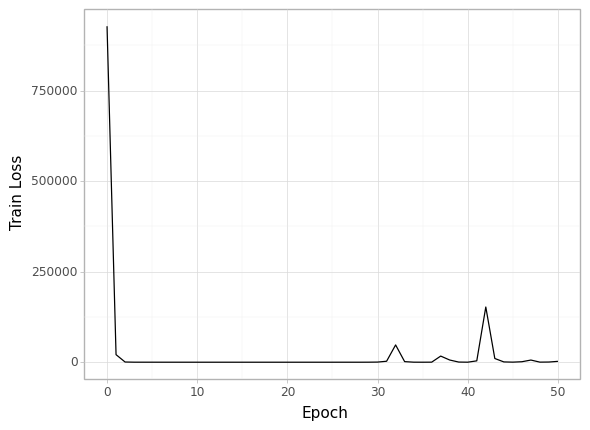

<ggplot: (8757435712847)>

In [181]:
# plot loss func.
(
    ggplot(train_scores, aes(x='Epoch', y='Train Loss'))
        + geom_line(color='black')
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [182]:
# model_load
model.load_state_dict(torch.load(os.path.join(cfg.base_path, "model", f'{cfg.model_name}_best_scores.pth')))

<All keys matched successfully>

In [194]:
def plot_hist(train_scores, test_scores, threshold):
    # 히스토그램
    fig = plt.figure(figsize=(10,8))
    plt.hist(train_scores, bins=50, density=True, alpha=0.7, label='Train data')
    plt.hist(test_scores, bins=5000, density=True, alpha=0.7, label='Test data')
    plt.axvline(x=threshold, c='red', linestyle=':', label='Threshold')
    plt.title("Score")
    plt.xlim(0,10000)
    plt.legend()
    plt.show()
    
def get_pred_label(model_pred, threshold):
    # (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred <= threshold, 0, model_pred)
    model_pred = np.where(model_pred > threshold, 1, model_pred)
    return model_pred

(2447,)
(7389,)


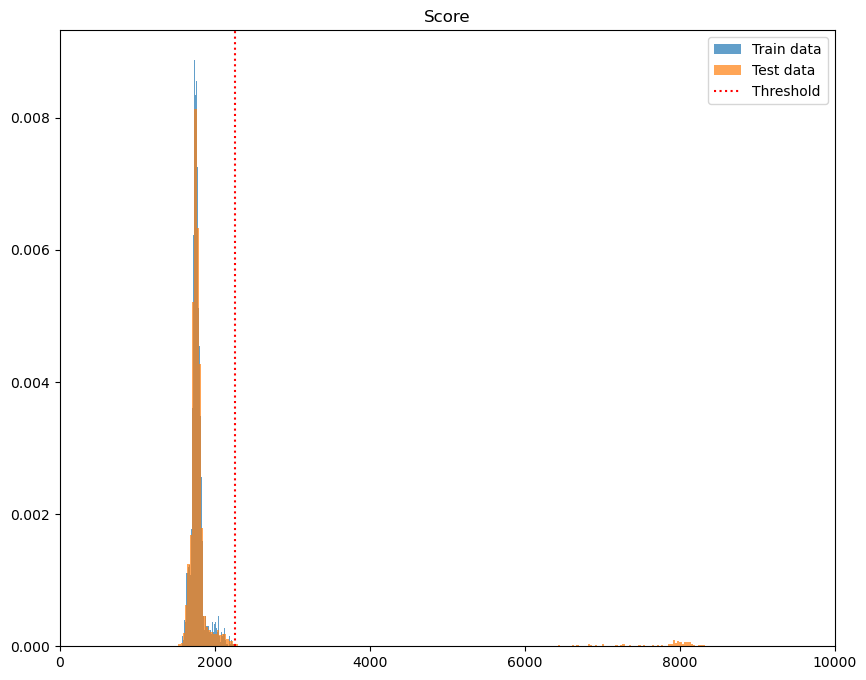

Counter({0.0: 7038, 1.0: 351})


In [195]:
# with torch.no_grad():
#     for j,x in enumerate(train_dataloader):
#         x = x.to(cfg.device)
#         optimizer.zero_grad()
#         output = model.forward(x)
#         break

train_scores = evaluation(model, train_dataloader)
print(train_scores.shape)
threshold=train_scores.max()

test_scores = evaluation(model, test_dataloader)
print(test_scores.shape)

plot_hist(train_scores, test_scores, threshold)
test_pred = get_pred_label(test_scores, threshold)
print(Counter(test_pred))

In [196]:
Counter(test_pred[outlier_pressure])

Counter({1.0: 7})

In [197]:
# 제출파일 생성
def make_submission(label, filename):
    submission = pd.read_csv("./answer_sample.csv")
    submission.label = label
    submission.to_csv(f"./submission/{filename}.csv", index=False)

In [208]:
now = datetime.strftime(datetime.now(),"%m%d%H%M")

In [210]:
cfg.model_name + now

'DeepSVDD_04111556'

In [212]:
make_submission(test_pred, cfg.model_name+"_"+now)

## Submission

In [48]:
import pendulum
from datetime import datetime

t = pendulum.now()
t.strftime('%m%d%H%M')


'04062342'

In [33]:
submission

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,0
7386,7,0
7387,7,0


In [34]:
submission.label.value_counts()

0    7129
1     260
Name: label, dtype: int64

In [36]:
submission.to_csv("./submission/standard_oversampling_basicAE_062145.csv")